# Getting started


Let's start by importing the packages we'll need. As usual, we'll import pandas for exploratory analysis, but this week we're also going to use the cluster subpackage from scikit-learn to create agglomerative clustering models and the standard Python package urllib2 to download documents from Project Gutenberg.

In [8]:
%matplotlib inline
import pandas as pd
# import urllib as urllib2
from urllib.request import urlopen

from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In this lab, we're going to cluster documents by the similarity of their text content. For this, we'll need to download some documents to cluster. The following dictionary maps the names of various texts to their corresponding URLs at [Project Gutenberg](https://www.gutenberg.org/).

In [13]:
urls = {
    'The Iliad - Homer': 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt',
    'The Odyssey - Homer': 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt',
    'Romeo and Juliet - William Shakespeare': 'https://www.gutenberg.org/cache/epub/1112/pg1112.txt',
    'Hamlet - William Shakespeare': 'https://www.gutenberg.org/files/1524/1524-0.txt',
    'Adventures of Huckleberry Finn - Mark Twain': 'https://www.gutenberg.org/files/76/76-0.txt',
    'The Adventures of Tom Sawyer - Mark Twain': 'https://www.gutenberg.org/files/74/74-0.txt',
    'A Tale of Two Cities - Charles Dickens': 'https://www.gutenberg.org/files/98/98-0.txt',
    'Great Expectations - Charles Dickens': 'https://www.gutenberg.org/files/1400/1400-0.txt',
    'Oliver Twist - Charles Dickens': 'https://www.gutenberg.org/cache/epub/730/pg730.txt'
    # 'The Adventures of Sherlock Holmes - Arthur Conan Doyle': 'https://www.gutenberg.org/cache/epub/1661/pg1661.txt'
}

Next, we need to download the texts located at the URLs. We can do this using Python's urllib2 package, which is part of the standard Python library. The following code will download the content of each URL and store it in the documents dictionary:

In [ ]:
# Documents from the article
documents = {}
for name, url in urls.items():
    print(name)
    response = urlopen(url)
    document = response.read()
    print(document)
    print('=====')
    documents[name] = document

In [ ]:
# Example documents from Markdown content
# Uncomment to use our example.

Finally, we can create a pandas data frame to represent our document data:

In [15]:
df = pd.DataFrame([documents[name] for name in sorted(documents)], index=sorted(documents), columns=['text'])

df.head(10)

,text
A Tale of Two Cities - Charles Dickens,b'\xef\xbb\xbfThe Project Gutenberg eBook of A...
Adventures of Huckleberry Finn - Mark Twain,b'\xef\xbb\xbfThe Project Gutenberg eBook of A...
Great Expectations - Charles Dickens,b'\xef\xbb\xbfThe Project Gutenberg eBook of G...
Hamlet - William Shakespeare,b'\xef\xbb\xbfThe Project Gutenberg eBook of H...
Oliver Twist - Charles Dickens,b'\xef\xbb\xbfThe Project Gutenberg eBook of O...
Romeo and Juliet - William Shakespeare,b'\xef\xbb\xbfThe Project Gutenberg EBook of R...
The Adventures of Tom Sawyer - Mark Twain,b'\xef\xbb\xbfThe Project Gutenberg eBook of T...
The Iliad - Homer,b'\xef\xbb\xbfThe Project Gutenberg eBook of T...
The Odyssey - Homer,b'\xef\xbb\xbfThe Project Gutenberg eBook of T...


# Data modelling

Let's build an agglomerative clustering model of the document data. As with $K$-means clustering, scikit-learn supports agglomerative clustering functionality via the cluster subpackage. We can use the AgglomerativeClustering class to build our model.

As with other scikit-learn estimators, AgglomerativeClustering accepts a number of different hyperparameters. We can get a list of these modelling parameters using the get_params method of the estimator (this works on any scikit-learn estimator), like this

In [16]:
AgglomerativeClustering().get_params()

{'affinity': 'euclidean',
 'compute_distances': False,
 'compute_full_tree': 'auto',
 'connectivity': None,
 'distance_threshold': None,
 'linkage': 'ward',
 'memory': None,
 'n_clusters': 2}

You can find a more detailed description of each parameter in the `scikit-learn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

As our data is in text format, we'll need to convert it into a numerical representation so that it can be understood by the clustering algorithm. One way to do this is by converting the document texts into vectors of TF-IDF scores, just as we did when building the spam classifier. This way, the clustering algorithm will identify documents with similar TF-IDF score vectors. This should result in clusters containing documents with similar text content, because if two documents have similar TF-IDF vectors, then they must contain the same words, occurring with the same frequencies.

> Note: Comparing TF-IDF score vectors is one - but not the only - way to determine whether documents have similar content.

As with the spam classification example, we can use a pipeline to connect the `TfidfVectorizer` to the `AgglomerativeClustering` algorithm. Because of a snag in the way `scikit-learn` is coded, the `AgglomerativeClustering` class only accepts dense matrices as inputs and, unfortunately, `TfidfVectorizer` produces sparse matrix output. However, this is easily recified by inserting a [`FunctionTransformer`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer) (essentially, a custom function) between the two that converts the sparse input to dense input.

The code specifying the pipeline and fitting the data is shown below. Note that, as with $K$-means clustering, agglomerative clustering is an unsupervised learning algorithm, and so we don't need to specify a target variable ($y$) when fitting the model.

In [17]:
X = df['text']

# Construct a pipeline: TF-IDF -> Sparse to Dense -> Clustering
pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
    AgglomerativeClustering(linkage='average')  # Use average linkage
)

pipeline = pipeline.fit(X)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Once we've fitted the data to the pipeline, we can extract the fitted agglomerative clustering model to see what clusters were formed. To extract the model, we can use the named_steps attribute of the pipeline, which is a dictionary mapping the names (in lowercase) of each stage in the pipeline to the corresponding models.

In [18]:
pipeline.named_steps

{'tfidfvectorizer': TfidfVectorizer(stop_words='english'),
 'functiontransformer': FunctionTransformer(accept_sparse=True,
                     func=<function <lambda> at 0x7fae2d92bca0>),
 'agglomerativeclustering': AgglomerativeClustering(linkage='average')}

As can be seen, our clustering model is stored under the key `'agglomerativeclustering'`, and so we can extract it as follows:

In [19]:
model = pipeline.named_steps['agglomerativeclustering']

Currently, `scikit-learn` does not support plotting dendrograms out of the box. However, the authors have provided the following code snippet for anyone who wants to do so:

In [21]:
# Original source: https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
import numpy as np

from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0] + 2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Finally, we can call the `plot_dendrogram` function to plot a dendrogram of our model, as follows:

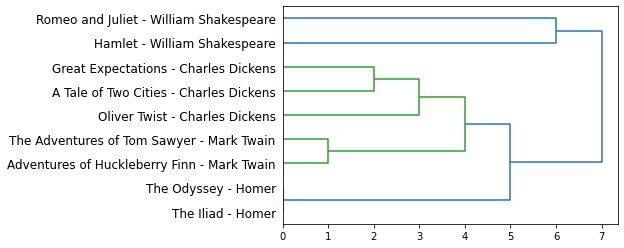

In [22]:
plot_dendrogram(model, labels=X.index, orientation='right')

As can be seen, clustering by TF-IDF score vectors results in texts written by the same author or at roughly the same point in time being grouped together. This makes sense when you consider that TF-IDF scores represent the frequency of use of certain terms, which may be indicative of an individual author's style or the style of writing at a certain point in history.